## Value of an European Call Option

The [Black-Scholes-Merton](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) model is a 
mathematical model applicable in financial markets containing derivative investment instruments for 
the theoretical estimation of European-style options' price. According to such model, 
__the index level at maturity__ of a call option can be modeled as it follows with z normally distributed

$$S_T(z)=S_0e^{(r-0.5\sigma^2)T+\sigma\sqrt{T}z}$$

where 
* $S_0$ is the initial stock index level
* K is the strike price of the European call option
* T is the Time-to-maturity in year 
* r is the riskless short rate 
* $\sigma^2$ is the volatility

Let's assume the following values 
* $S_0 = 105$
* K = 109 
* T = 1 
* r = 6% 
* $\sigma^2$ = 22%

In order to calculate the present value of the call option, it is possible to apply a Monte Carlo approach
according to the following procedure: 
* Let's consider R realizations of the random variable z from a standard normal distribution 
* Compute related index levels at maturity $S_T(i)$ for $z(i)\in\{1,2,...,R\}$ 
* Compute the call option value $h_T(i)=\max{(S_T(i)–K,0)}$. 
* Compute the __present value__ of the call option, i.e. 

$$C_0=e^{-rT}{R}^{-1}\sum_{i=1}^{R} h_T{(i)}$$



In [59]:
import numpy as np

def bsm(S0,r,sigma,T,K,R = 100000 , seed=500):
    np.random.seed(seed)
    z = np.random.standard_normal(R) 
    ST = S0 * np.exp(( r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)
    hT = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.sum(hT) / R
    return C0

In [60]:
import time
tm = time.time()
C0 = bsm(S0=105,r=0.06,sigma=0.22,T=1.0,K=109,R = 100000 , seed=500)
pm = time.time() - tm
print("Value of European Call Option: {0:.4g}".format(C0)+" - time[{0:.4g} secs]".format(pm))

Value of European Call Option: 10.31 - time[0.009614 secs]


Let's see how much time is necessary for 70,000,000 iterations intead of 100,000 iterations. 

In [61]:
tm = time.time()
C0 = bsm(S0=105,r=0.06,sigma=0.22,T=1.0,K=109,R = 70000000 , seed=500)
pm = time.time() - tm
print("Value of European Call Option: {0:.4g}".format(C0)+" - time[{0:.4g} secs]".format(pm))

Value of European Call Option: 10.32 - time[6.338 secs]


Let's see how we can speed up the computation with the __numexpr__ package. 

In [62]:
import numexpr as ne
def bsm_ne(S0,r,sigma,T,K,R = 70000000 , seed=500):
    np.random.seed(seed)
    z = np.random.standard_normal(R) 
    ST = ne.evaluate('S0 * exp(( r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * z)')
    hT = np.maximum(ST - K, 0)
    C0 = np.exp(-r * T) * np.sum(hT) / R
    return C0

In [63]:
tm = time.time()
C0 = bsm_ne(S0=105,r=0.06,sigma=0.22,T=1.0,K=109,R = 70000000 , seed=500)
pm = time.time() - tm
print("Value of the European Call Option: {0:.4g}".format(C0)+" - time[{0:.4g} secs]".format(pm))

Value of the European Call Option: 10.32 - time[4.34 secs]


## Plotting the return of a stock 

The __daily return__ of a stock is easily computable as it follows  $$dr(t)=\frac{P(t)}{P(t-1)}-1$$
Similarly, the __cumulative return__ of a stock  is easily computable as it follows $$cr(t)=\frac{P(t)}{P(0)}-1$$
What is it P(t)? There are basically 2 options for this value, i.e. 
* the __adjusted close price__ of a stock typically indicated in financial feed as __Adj Close__, or 
* the __close price__ of a stock typically indicated in financial feed as __Adj__. 

We take the __adjusted close price__ 
(see [What Hedge Funds Really Do](https://www.amazon.com/What-Hedge-Funds-Really-Introduction-ebook/dp/B00MYFT0TQ#nav-subnav)
to understand why).                                     
   
 
### Get financial data 
Functions from __pandas.io.data__ and __pandas.io.ga__ extract data from various Internet sources into a __DataFrame__
The following sources are supported:

* Yahoo! Finance
* Google Finance
* St.Louis FED (FRED)
* Kenneth French’s data library
* World Bank
* Google Analytics

For further info see [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/remote_data.html)

In [104]:
import numpy as np
import pandas as pd
import pandas.io.data as web


symbols = ['GOOG','SPY']
df_final = web.DataReader(symbols, data_source='yahoo',
                      start='1/21/2010', end='4/15/2016')

print(df_final)
print(df_final.shape)

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 1570 (major_axis) x 2 (minor_axis)
Items axis: Open to Adj Close
Major_axis axis: 2010-01-21 00:00:00 to 2016-04-15 00:00:00
Minor_axis axis: GOOG to SPY
(6, 1570, 2)


In [105]:
df_final.ix[:,:,'SPY'].head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-21,113.919998,114.269997,111.559998,111.699997,344859600.0,97.864196
2010-01-22,111.199997,111.739998,109.089996,109.209999,345942400.0,95.682624
2010-01-25,110.209999,110.410004,109.410004,109.769997,186937500.0,96.173257
2010-01-26,109.339996,110.470001,109.040001,109.309998,211168800.0,95.770236
2010-01-27,109.169998,110.080002,108.330002,109.830002,271863600.0,96.225829


In [106]:
print(type(df_final.ix[:,:,'SPY']))
print("\n>>> null values:"+str(pd.isnull(df_final.ix[:,:,'GOOG']).sum().sum()))

<class 'pandas.core.frame.DataFrame'>

>>> null values:0


In [107]:
df_final = web.DataReader(symbols, data_source='yahoo',
                      start='1/21/1999', end='4/15/2016')
df_final.ix[:,:,'GOOG'].head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1999-01-21,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-22,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-25,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-26,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-27,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
print(type(df_final.ix[:,:,'GOOG']))
print("\n>>> null values:"+str(pd.isnull(df_final.ix[:,:,'GOOG']).sum().sum()))

<class 'pandas.core.frame.DataFrame'>

>>> null values:8412


There is a couple of observations to be done:
1. calling __pandas.io.data__ with multiple stocks gets a __pandas.core.panel.Panel__ instead of a __pandas.DataFrame__
but filtering to specific axis (e.g. Google) we get __pandas.core.frame.DataFrame__
2. __pandas.io.data__ does not handle missing values 

Hence, we can define the following functions.  

In [114]:
import matplotlib.pyplot as plt
def get_data(symbols, 
             add_ref=True,
             data_source='yahoo',
             price='Adj Close',
             start='1/21/2010', 
             end='4/15/2016'):
    """Read stock data (adjusted close) for given symbols from."""
    
    if add_ref and 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    df = web.DataReader(symbols, 
                        data_source=data_source,
                        start=start, 
                        end=end)
    
    return df[price,:,:]

def plot_data(df_data):
    """Plot stock data with appropriate axis labels."""
    ax = df_data.plot(title="Stock Data", fontsize=2)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()


get_data(symbols=['GOOG','SPY']).tail()

,GOOG,SPY
Date,,
2016-04-11,736.099976,202.964506
2016-04-12,743.090027,204.854670
2016-04-13,751.719971,206.923911
2016-04-14,753.200012,206.933854
2016-04-15,759.000000,206.705048


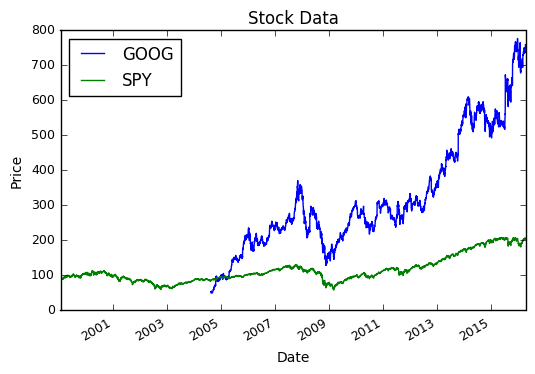

In [129]:
ax = get_data(symbols=['GOOG','SPY'],start='1/21/1999', end='4/15/2016').plot(title="Stock Data", fontsize=9)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()

As clear from above plot, we need to handle missing values. 

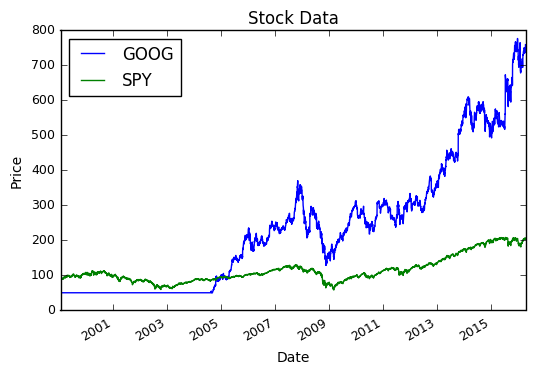

In [130]:
def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method='ffill',inplace=True)
    df_data.fillna(method='backfill',inplace=True)
    return df_data
ax = fill_missing_values(get_data(symbols=['GOOG','SPY'],
                             start='1/21/1999', 
                             end='4/15/2016')).plot(title="Stock Data", fontsize=9)
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()